All code taken (with light modification) from 
https://github.com/MichaelAllen1966/synthetic_data_pilot/blob/main/01_wisconsin/03b_CTGAN_log_regression.ipynb

In [3]:
from IPython.display import clear_output

from ctgan import CTGANSynthesizer
ctgan = CTGANSynthesizer()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")

In [11]:
pd.read_csv('../data/back_pain.csv')

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,Normal,NaN
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,Normal,NaN
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,Normal,NaN
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,Normal,NaN


## Data Import Functions

In [15]:
def load_data():
    """"
    Load Back Pain Data Set
    
    Inputs
    ------
    None
    
    Returns
    -------
    X: NumPy array of X
    y: Numpy array of y
    col_names: column names for X
    """    
    
    # Load data and drop 'id' column
    data = pd.read_csv('../data/back_pain.csv')
    # Drop the unnamed column
    data.drop('Unnamed: 13', axis=1, inplace=True)

    # Change 'Class_att' column to 'label', and put in last column place
    data['label'] = data['Class_att'] == 'Abnormal'
    data.drop('Class_att', axis=1, inplace=True)

    # Split data in X and y
    X = data.drop(['label'], axis=1)
    y = data['label'] * 1.0 # convert to 0/1
    
    # Get col names and convert to NumPy arrays
    X_col_names = list(X)
    X = X.values
    y = y.values
    
    return data, X, y, X_col_names

In [16]:
def split_into_train_test(X, y, test_proportion=0.25):    
    """"
    Randomly split X and y numpy arrays into training and test data sets
    
    Inputs
    ------
    X and y NumPy arrays
    
    Returns
    -------
    X_test, X_train, y_test, y_train Numpy arrays
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, shuffle=True, test_size=test_proportion)
        
    return X_train, X_test, y_train, y_test

In [17]:
def standardise_data(X_train, X_test):
    """"
    Standardise training and tets data sets according to mean and standard
    deviation of test set
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    X_train_std, X_test_std
    """
    
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    X_train_std = (X_train - mu) / std
    X_test_std = (X_test - mu) /std
    
    return X_train_std, X_test_std

## Evaluation Functions

In [18]:
def calculate_diagnostic_performance(actual, predicted):
    """     
    Inputs
    ------
    actual, predted numpy arrays (1 = +ve, 0 = -ve)
    
    Returns
    -------
    A dictionary of results:
    
    1)  accuracy: proportion of test results that are correct    
    2)  sensitivity: proportion of true +ve identified
    3)  specificity: proportion of true -ve identified
    4)  positive likelihood: increased probability of true +ve if test +ve
    5)  negative likelihood: reduced probability of true +ve if test -ve
    6)  diagnostic odds ratio: positive likelihood / negative likelihood
    7)  true positive rate: same as sensitivity
    8)  true negative rate: same as specificity
    9)  false positive rate: proportion of false +ves in true -ve patients
    10) false negative rate:  proportion of false -ves in true +ve patients
    11) positive predictive value: chance of true +ve if test +ve
    12) negative predictive value: chance of true -ve if test -ve
    13) actual positive rate: proportion of actual values that are +ve
    14) predicted positive rate: proportion of predicted vales that are +ve
    15) recall: same as sensitivity
    16) precision: the proportion of predicted +ve that are true +ve
    17) f1: 2 * ((precision * recall) / (precision + recall))

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    
    # Calculate results 
    actual_positives = actual == 1
    actual_negatives = actual == 0
    test_positives = predicted == 1
    test_negatives = predicted == 0
    
    test_correct = actual == predicted
    accuracy = test_correct.mean()
    
    true_positives = actual_positives & test_positives
    false_positives = test_positives & actual_negatives
    true_negatives = actual_negatives & test_negatives
    false_negatives = test_negatives & actual_positives
    
    sensitivity = true_positives.sum() / actual_positives.sum()
    specificity = true_negatives.sum() / actual_negatives.sum()

    true_positive_rate = sensitivity
    true_negative_rate = specificity
    false_positive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    
    positive_likelihood = true_positive_rate / false_positive_rate
    negative_likelihood = false_positive_rate / true_negative_rate
    diagnostic_odds_ratio = positive_likelihood / negative_likelihood
    
    positive_predictive_value = true_positives.sum() / test_positives.sum()
    negative_predicitive_value = true_negatives.sum() / test_negatives.sum()
    
    actual_positive_rate = actual.mean()
    predicted_positive_rate = predicted.mean()
    
    recall = sensitivity
    precision = true_positives.sum() / actual_positives.sum()
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    # Add results to dictionary
    results = dict()
    results['accuracy'] = accuracy
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['diagnostic_odds_ratio'] = diagnostic_odds_ratio
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    results['actual_positive_rate'] = actual_positive_rate
    results['predicted_positive_rate'] = predicted_positive_rate
    results['recall'] = recall
    results['precision'] = precision
    results['f1'] = f1
   
    return results

In [19]:
def fit_and_test_logistic_regression_model(X_train, X_test, y_train, y_test):    
    """"
    Fit and test logistic regression model. 
    Return a dictionary of accuracy measures.
    Calls on `calculate_diagnostic_performance` to calculate results
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    A dictionary of accuracy results.
    """
    
    # Fit logistic regression model 
    lr = LogisticRegression(C=0.1)
    lr.fit(X_train,y_train)

    # Predict tets set labels
    y_pred = lr.predict(X_test_std)
    
    # Get accuracy results
    accuracy_results = calculate_diagnostic_performance(y_test, y_pred)
    
    return accuracy_results

## Data Synthesis (CTGAN) Functions

In [20]:
def make_synthetic_data_gan(X_original, y_original, number_of_samples=1000, 
                            epochs=1000):
    
    """
    Synthetic data generation, using a GAN
    
    Inputs
    ------
    original_data: X, y numpy arrays
    batch_size: batch size to use when training networks
    latent_dim: input dimension for generator network
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
 
    # Split the training data into positive and negative
    mask = y_original == 1
    X_pos = X_original[mask]
    mask = y_original == 0
    X_neg = X_original[mask]

    # Set up list for positive and negative synthetic data sets
    synthetic_X_sets = []
    
    # Generate positive class data
    ctgan.fit(X_pos, epochs=epochs)
    x_fake_pos = ctgan.sample(number_of_samples)
    synthetic_X_sets.append(x_fake_pos)
    
    # Generate negative class data
    ctgan.fit(X_neg, epochs=epochs)
    x_fake_neg = ctgan.sample(number_of_samples)
    synthetic_X_sets.append(x_fake_neg)
        
    # Combine positive and negative and shuffle rows
    X_synthetic = np.concatenate(
            (synthetic_X_sets[0], synthetic_X_sets[1]), axis=0)

    y_synthetic_pos = np.ones((number_of_samples, 1))
    y_synthetic_neg = np.zeros((number_of_samples, 1))
    y_synthetic = np.concatenate((y_synthetic_pos, y_synthetic_neg), axis=0)

    # Randomise order of X, y
    synthetic = np.concatenate((X_synthetic, y_synthetic), axis=1)
    shuffle_index = np.random.permutation(np.arange(X_synthetic.shape[0]))
    synthetic = synthetic[shuffle_index]
    X_synthetic = synthetic[:,0:-1]
    y_synthetic = synthetic[:,-1]
                                                                   
    return X_synthetic, y_synthetic

# Create Synthetic Data

In [21]:
# Load data
original_data, X, y, X_col_names = load_data()

# Set up results DataFrame
results = pd.DataFrame()

In [22]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names

1 Accuracy: 87.2
2 Accuracy: 84.6
3 Accuracy: 79.5
4 Accuracy: 82.1
5 Accuracy: 80.8


In [23]:
# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

# Set number of replicate runs
number_of_runs = 5

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')

    # Make synthetic data
    X_synthetic, y_synthetic = make_synthetic_data_gan(X, y)
    clear_output(wait=True)

    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)

    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)

    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')
    
    # Save synthetic data set
    # -----------------------
    
    # Create a data frame with id
    synth_df = pd.DataFrame()

    # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X_col_names)],
                        axis=1)

    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)
    
# Store mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['gan_mean'] = accuracy_array.mean(axis=0)
results['gan_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

Accuracy: 51.3


In [35]:
# Save the datasets
for i, dataset in enumerate(synthetic_data):
    # Change back to original target column mapping
    dataset['label'] = dataset['label'].map({1.0: 'Abonormal', 0.0: 'Normal'})
    # Change back to original column name
    dataset.rename({'label':'Class_att'}, axis=1)
    # Write dataset to csv file
    dataset.to_csv('../syn_data/back_pain_ctgan_mike_v' + str(i))

## Compare raw and synthetic data means and standard deviations

In [24]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
  
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        original_data[original_data['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        original_data[original_data['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        original_data[original_data['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        original_data[original_data['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

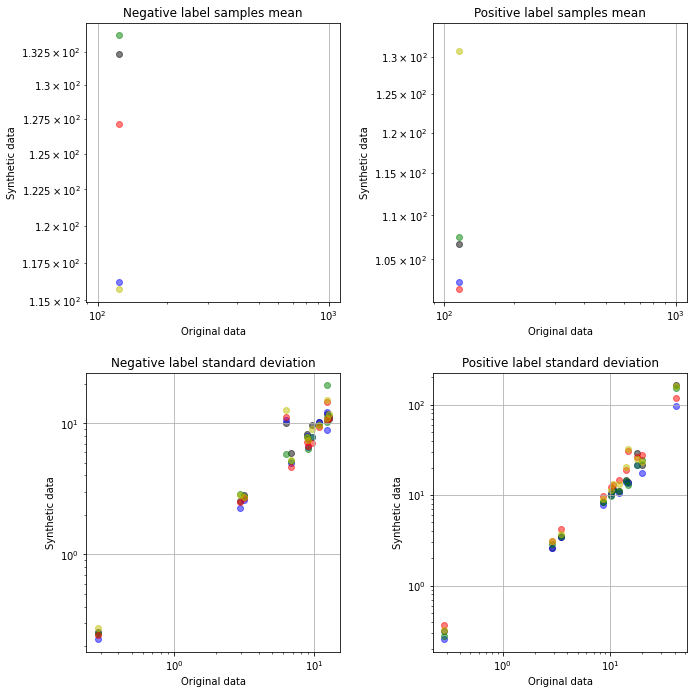

In [26]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Negative label mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive label mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative label standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive label standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('../output/ctgan_correls.png', facecolor='w', dpi=300)
plt.show()

In [28]:
correl_mean_neg = []
correl_std_neg = []
correl_mean_pos = []
correl_std_pos = []

for run in range(number_of_runs):
    # Get correlation of means
    x = descriptive_stats_all_runs[run]['Original neg_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean']
    correl_mean_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean']
    correl_mean_pos.append(np.corrcoef(x,y)[0,1])
    
    # Get correlation of standard deviations
    x = descriptive_stats_all_runs[run]['Original neg_label std']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std']
    correl_std_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label std']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std']
    correl_std_pos.append(np.corrcoef(x,y)[0,1])

# Get correlation of means
mean_r_square_mean_neg = np.mean(np.square(correl_mean_neg))
mean_r_square_mean_pos = np.mean(np.square(correl_mean_pos))
sem_square_mean_neg = np.std(np.square(correl_mean_neg))/np.sqrt(number_of_runs)
sem_square_mean_pos = np.std(np.square(correl_mean_pos))/np.sqrt(number_of_runs)

print ('R-square of means (negative), mean (std): ', end='')
print (f'{mean_r_square_mean_neg:0.3f} ({sem_square_mean_neg:0.3f})')
print ('R-square of means (positive), mean (std): ', end='')
print (f'{mean_r_square_mean_pos:0.3f} ({sem_square_mean_pos:0.3f})')

# Get correlation of standard deviations
mean_r_square_sd_neg = np.mean(np.square(correl_std_neg))
mean_r_square_sd_pos = np.mean(np.square(correl_std_pos))
sem_square_sd_neg = np.std(np.square(correl_std_neg))/np.sqrt(number_of_runs)
sem_square_sd_pos = np.std(np.square(correl_std_pos))/np.sqrt(number_of_runs)

print ('R-square of standard deviations (negative), mean (sem): ', end='')
print (f'{mean_r_square_sd_neg:0.3f} ({sem_square_sd_neg:0.3f})')
print ('R-square of standard deviations (positive), mean (sem): ', end='')
print (f'{mean_r_square_sd_pos:0.3f} ({sem_square_sd_pos:0.3f})')

R-square of means (negative), mean (std): 0.973 (0.003)
R-square of means (positive), mean (std): 0.794 (0.058)
R-square of standard deviations (negative), mean (sem): 0.827 (0.020)
R-square of standard deviations (positive), mean (sem): 0.843 (0.015)


## Single Run Example

In [27]:
descriptive_stats_all_runs[0]

,Original pos_label mean,Synthetic pos_label mean,Original neg_label mean,Synthetic neg_label mean,Original pos_label std,Synthetic pos_label std,Original neg_label std,Synthetic neg_label std
Col1,64.692562,75.015270,51.685244,51.986294,17.662129,29.123161,12.368161,11.834325
Col2,19.791111,15.529433,12.821414,6.517775,10.515871,11.709868,6.778503,5.982251
Col3,55.925370,67.207964,43.542605,37.676211,19.669471,21.500430,12.361388,11.062334
Col4,44.901450,53.075890,38.863830,37.982805,14.515560,13.958480,9.624004,9.706344
Col5,115.077713,106.737261,123.890834,132.298720,14.090605,14.847606,9.014246,7.527587
Col6,37.777705,132.980734,2.186572,8.751918,40.696741,163.017696,6.307483,10.023465
Col7,0.483979,0.544410,0.449880,0.297438,0.286319,0.316005,0.284711,0.254524
Col8,21.085875,14.938151,21.816394,28.019385,8.550365,8.489274,8.846484,8.275361
Col9,12.948913,10.040204,13.307268,11.738475,3.516762,3.476075,3.142902,2.864169
Col10,12.132737,12.841353,11.514534,10.694618,2.848401,2.613727,2.955985,2.557848


## Correlation between features

In [29]:
neg_correlation_original = []
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = original_data['label'] == 0
neg_o = original_data[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = original_data['label'] == 1
pos_o = original_data[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    correl_coeff_neg.append(np.corrcoef(
        neg_correlation_original, corr_neg_s)[0,1])

    correl_coeff_pos.append(np.corrcoef(
        pos_correlation_original, corr_pos_s)[0,1])

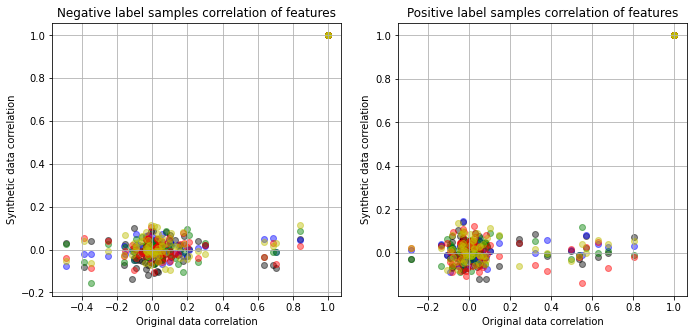

In [31]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
plt.savefig('../output/ctgan_cov.png', facecolor='w', dpi=300)
plt.show()

In [32]:
r_square_neg_mean = np.mean(np.square(correl_coeff_neg))
r_square_pos_mean = np.mean(np.square(correl_coeff_pos))
r_square_neg_sem = np.std(np.square(correl_coeff_neg))/np.sqrt(number_of_runs)
r_square_pos_sem = np.std(np.square(correl_coeff_pos))/np.sqrt(number_of_runs)

print ('Corrleation of correlations (negative), mean (sem): ', end='')
print (f'{r_square_neg_mean:0.3f} ({r_square_neg_sem:0.3f})')
print ('Corrleation of correlations (positive), mean (sem): ', end = '')
print (f'{r_square_pos_mean:0.3f} ({r_square_pos_sem:0.3f})')

Corrleation of correlations (negative), mean (sem): 0.624 (0.008)
Corrleation of correlations (positive), mean (sem): 0.613 (0.012)
